## Import & Setup

Note, if you are getting errors like this:
```
...
from .extension import *
  File ".../isaacsim/extsUser/go4robo/go4robo_python/extension.py", line 3, in <module>
    import omni.ext
ModuleNotFoundError: No module named 'omni'
```

Go into `isaacsim/extsUser/go4robo/go4robo_python/__init__.py` and comment out the following line:
```
from .extension import *
```

!! You need to uncomment this line if you plan to run the Isaac Sim extension !!

In [142]:
#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

%pip install -q usd-core
%pip install -q pymoo

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_problem import *
from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_rep import *

import json

import os, sys

import copy

import plotly.graph_objects as go
import seaborn as sns
import pandas as pd

from tqdm.notebook import trange, tqdm

sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
10214.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
10220.37s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


### Put the run ID here

In [143]:
run_date_string = "20250503"
run_time_string = "191240"

run_id = f"{run_date_string}_{run_time_string}"

## Get the generated designs from csv

In [144]:
df_csv_path = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/designs_Robot_{run_id}.csv" # This should also contain the prior design at index 0

df = pd.read_csv(df_csv_path)
df

,id,Name,Cost,Perception Entropy,Generation,s0_type,s0_x,s0_y,s0_z,s0_qw,...,s3_qy,s3_qz,s4_type,s4_x,s4_y,s4_z,s4_qw,s4_qx,s4_qy,s4_qz
0,0,Prior Design,2.0,1.265471,0,1,0.000000,0.000000,0.500000,1.000000,...,0.000000,0.000000,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,1,Design 1,2.0,16.053420,1,1,1.540477,0.231729,-0.240302,-0.645301,...,0.000000,0.000000,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,2,Design 2,3.0,17.102970,1,1,1.273209,0.493913,0.046071,0.235124,...,0.000000,0.000000,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,3,Design 3,3.0,15.753482,1,1,0.883809,0.081577,0.489752,-0.463815,...,0.000000,0.000000,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,4,Design 4,3.0,8.602340,1,2,1.687681,-0.118984,0.249858,0.866384,...,0.000000,0.000000,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13926,13926,Design 13926,1.0,2.553935,199,2,0.499989,0.260439,0.534899,-0.673151,...,0.000000,0.000000,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
13927,13927,Design 13927,2.0,-1.929578,199,1,0.499517,0.282965,0.500000,-0.255612,...,0.000000,0.000000,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
13928,13928,Design 13928,5.0,-6.840282,199,1,0.499385,0.282914,0.500001,-0.627171,...,0.050726,-0.025747,1,0.0,0.0,0.532375,1.0,0.0,0.0,0.0
13929,13929,Design 13929,1.0,2.554124,199,2,0.499989,0.283300,0.534899,-0.701262,...,0.000000,0.000000,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## Plot the tradespace

Conveniently you can do this without the Problem definition, assuming you used the standard problem definition.

In [145]:
plot_tradespace(df)

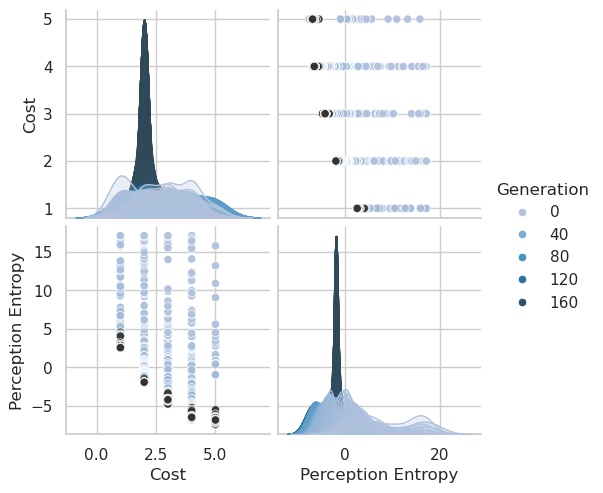

In [146]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1)

pair_plot_df = df[["Generation", "Cost", "Perception Entropy"]]
sns.pairplot(pair_plot_df, 
             hue="Generation", 
             diag_kind="kde",
             palette="PuBu_d")


## Set up the problem from json

In [147]:
json_prolem_path = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/problem_Robot_{run_id}.json" # This will contain the prior design at problem.prior_bot

problem_json_dict = json.load(open(json_prolem_path, 'r'))

problem = SensorPkgOptimization.from_json(problem_json_dict)

## Plot any bot from the df above

### Helper fns and data

In [148]:
sensor_constraints_mesh_data = box_mesh_data(problem.s_bounds, color="blue", opacity=0.2, name="Sensor Pos Constraints")

def plot_plot_design(design_idx, sensor_idx_rays=None, max_rays=100):
    design_x_dict = df[df["id"] == design_idx].iloc[0].to_dict()
    bot_x = problem.convert_1D_to_bot(design_x_dict)
    sensor_x:Sensor3D_Instance = bot_x.sensors[sensor_idx_rays] if sensor_idx_rays is not None else None
    design_x_fig = bot_x.plot_bot_3d(
        perception_space=problem.perception_space,
        show=False,
        show_sensor_pose_constraints=False,
        width=600,
    )
    design_x_fig.add_trace(sensor_constraints_mesh_data)

    if sensor_x is not None:
        ro, rd = sensor_x.get_rays()
        sparse = int(ro.shape[0] / max_rays)
        sensor_x.plot_rays(ro, rd, sparse=sparse, fig=design_x_fig)
    
    design_x_fig.update_layout(
        title=f"Design {design_idx}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode="data",
        ),
        margin=dict(l=0, r=0, b=0, t=30),
    )

    return design_x_fig

### Plot any Bot!

In [152]:
# Here is the first one
design_0_fig = plot_plot_design(0, sensor_idx_rays=1, max_rays=100)

Found sensor type 1 in problem sensor options.
Found sensor type 2 in problem sensor options.


In [155]:
INDEX_TO_PLOT = 13861

design_x_fig = plot_plot_design(INDEX_TO_PLOT, sensor_idx_rays=0, max_rays=100)

Found sensor type 1 in problem sensor options.
Found sensor type 1 in problem sensor options.
Found sensor type 1 in problem sensor options.
Found sensor type 1 in problem sensor options.
Found sensor type 1 in problem sensor options.


## Random Testing

### Ray/Voxel Traversal (measurement) test case

In [150]:
ro, rd = torch.tensor([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0],[0.0, 0.0, 0.0]]), torch.tensor([[1.0, 0.0, 0.0],[0.0, 1.0, 0.0],[np.sqrt(0.5), np.sqrt(0.5), 0.0]])

simple_perception_space = PerceptionSpace(usd_context=None,
                                          voxel_groups=[PerceptionSpace.VoxelGroup(
                                                name="simple",
                                                voxels=['','','',''],
                                                voxel_centers=torch.tensor([
                                                    [-0.5, -0.5, 0.0],  # Behind the sensor, should have 0 hits
                                                    [0.0, 0.0, 0.0],    # At center of sensor, should have 3 hits
                                                    [0.5, 0, 0.0],      # Along x-axis, should have 1 hit
                                                    [1.0, 0.5, 0.0]     # Should have 0 hits
                                                    ]),
                                                voxel_sizes=torch.tensor([0.1,0.1,0.1,0.1]).unsqueeze(1),
                                          )
                                          ],
                                          weights=[1.0]
)

simple_sensor:Sensor3D_Instance = Sensor3D_Instance(
    sensor=Sensor3D(
        name="simple_sensor",
    ),
    path='',
    tf=((0, 0, 0), (1, 0, 0, 0)),
    name="simple_sensor_instance",
)
    

# display(torch.tensor([[1.0, 0, 0.5],[2.0, 0, 0.5]]).size())
# display(torch.tensor([0.5,0.5]).size())

one_ray_fig = simple_perception_space.plot_me(show=False, mode='boxes')
simple_sensor.plot_rays(ro, rd, show=False, fig=one_ray_fig, ray_length=1.25)


one_ray_fig

In [151]:
simple_perception_space.chunk_ray_voxel_intersections(ro, rd, verbose=True)
# simple_perception_space.batch_ray_voxel_intersections(ro, rd, verbose=True)

 Batch ray voxel intersection traversal took 0.00 seconds for 3 rays and 4 voxels.
  VOXEL HITS max: 3, min: 0


tensor([0, 3, 1, 0], device='cuda:0')